In [1]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import bepy as be
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, NMF, DictionaryLearning
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

#Dimensional reduction exists in the SampleSet object
sset = be.SampleSet()

# Load Data

In [66]:
gridSize = 50
sampName = 'M1B'
path = 'D:\\Dropbox (GaTech)\\Dropbox (GaTech)\\ME-DboxMgmt-Bassiri-Gharb\\BE_Active\\Kerisha\\M1B\\10-02-2019\\A1\\Measurements\\'
samp = be.Sample(path, gridSize, adjustphase=True)

#You can add multiple samples to the sample set object.
sset.addsample(samp, sampName, gridSize)

In [34]:
print("The grid measurements are: ", list(sset.samples[sampName].gridmeasurements.keys()))

The grid measurements are:  ['RT_SSPFM_10VN']


In [ ]:
sample = 'M1B'
meas = 'RT_SSPFM_10VN'

sspfm = sset.samples[sample].gridmeasurements[meas]

# Inspect the data for bad fits

Find Places in the SHO files where the fit return either an inf or Nan values both indicative of bad SHO fitting. The plot returned shows bad fit chirps against the aquistion number and the potential wavefunction

<IPython.core.display.Javascript object>


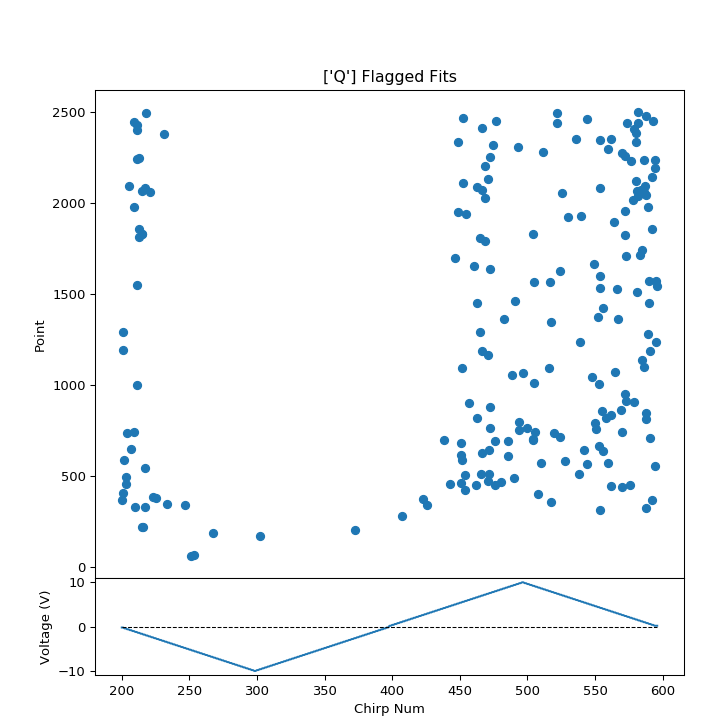

In [72]:
#What do you want to look at
stack = ['Q']
inout = None               # 0 for out of field, 1 for in-field


stack_len = len(stack)
test_var = stack[0]
num_points, t_length = sspfm.GetDataSubset(stack=[test_var], inout=inout).shape

bad_dict = {}

for var in stack:
    var_data = sspfm.GetDataSubset(stack=[var],inout=inout)
    chirps = var_data.columns.get_level_values('ChirpNum')
    points = var_data.index.values
    
    flags = np.logical_or(var_data == np.inf, var_data == -np.inf)
    flags = np.logical_or(flags, var_data == np.nan)
    
    point_ind, chirp_ind = np.where(flags)
    bad_chirps = chirps[chirp_ind]
    
    bad_list = np.array([(x,y) for x,y in zip(point_ind,bad_chirps)])
    
    bad_dict[var] = bad_list
    

for var in stack:
    bad_list = bad_dict[var]
    xvals = sspfm.GetDataSubset(stack=stack, inout=inout).columns.get_level_values('xaxis').astype(float)
    chirps = sspfm.GetDataSubset(stack=stack, inout=inout).columns.get_level_values('ChirpNum').astype(float)

    if bad_list.size != 0:
        f = plt.figure(figsize=(8,8))

        gs = gridspec.GridSpec(2, 1,hspace=0, height_ratios=[1,0.2])

        ax1 = plt.subplot(gs[0])
        ax1.scatter(bad_list[:,1],bad_list[:,0])
        ax1.set_ylabel('Point')
        plt.title(str(stack)+ ' Flagged Fits')

        ax2 = plt.subplot(gs[1])
        ax2.plot(chirps,xvals)
        ax2.plot(chirps,np.full(len(chirps),0),'k--',linewidth=0.8)
        ax2.set_ylabel('Voltage (V)')
        ax2.set_xlabel('Chirp Num')



Now plot the flagged points in X-Y space or as a MAP

<IPython.core.display.Javascript object>


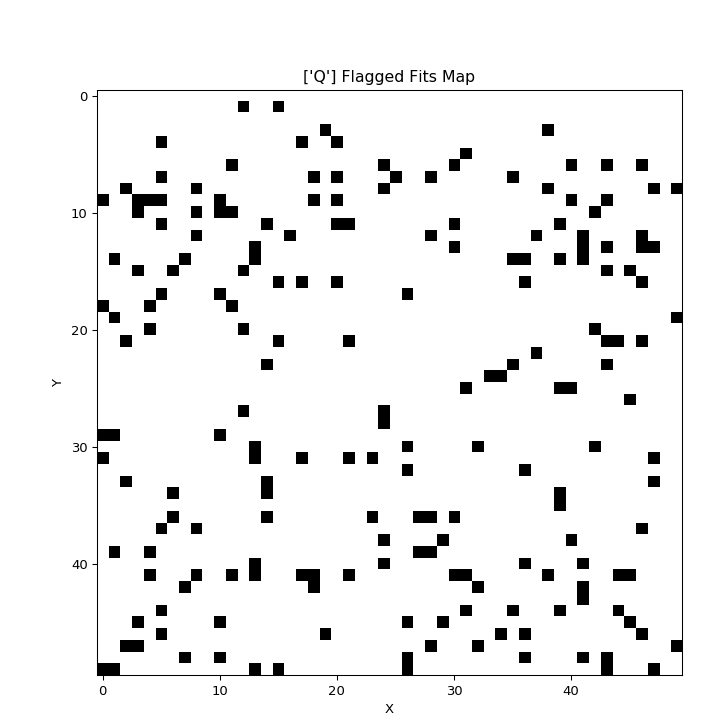

In [73]:
BL= np.full((2500),False)
BL[bad_list[:,0]]=True
Map_BL = BL.reshape(gridSize, gridSize)

plt.figure()
plt.imshow(Map_BL, cmap='binary')
plt.show()
plt.title(str(stack)+ ' Flagged Fits Map')
plt.xlabel('X')
plt.ylabel('Y')
fig = plt.gcf()
fig.set_size_inches(8, 8)

# Replace the Flagged Points with NAN

In [74]:
data = sspfm.data ###the data frame
data.iloc[bad_list[:,0]] = np.nan   ####using the the Bad list data to set these point to NaN. This only effects calculations of mean values and offsets

#Initialize remove flags
sset.samples[sampName].meas_acq_flags[SSPFM] = BL     #####ignore these pionts in the analysis model the flagged points that had bad SHO fits

In [33]:
sset.__dict__.keys()

dict_keys(['_samples', '_analysis', '_samp_acq_flags', '_gridsize'])

# Further Setup

In [75]:
#Limit Q
sset.samples[sample]._gridmeasurements[meas]._data['Q']=sset.samples[sample]._gridmeasurements[meas]._data['Q'].applymap(lambda x: 500 if x> 500 else x)

##sset._samples[sampName]._gridmeasurements[meas]._data = sset._samples[sampName]._gridmeasurements[meas]._data.fillna(axis=0,method='backfill')

# Remove the mean values from the data

In [76]:
sset.samples[sample]._gridmeasurements[meas]._data['Amp'] = sset.samples[sample]._gridmeasurements[meas]._data['Amp'].sub(sset.samples[sample]._gridmeasurements[meas]._data['Amp'].mean(axis=1, skipna=True), axis=0)  #### axis =1 to look across pionts in space (rows), skipna =True to skip NaN values
sset.samples[sample]._gridmeasurements[meas]._data['Phase'] = sset.samples[sample]._gridmeasurements[meas]._data['Phase'].sub(sset.samples[sample]._gridmeasurements[meas]._data['Phase'].mean(axis=1, skipna=True), axis=0)
sset.samples[sample]._gridmeasurements[meas]._data['PR'] = sset.samples[sample]._gridmeasurements[meas]._data['PR'].sub(sset.samples[sample]._gridmeasurements[meas]._data['PR'].mean(axis=1, skipna=True), axis=0)
sset.samples[sample]._gridmeasurements[meas]._data['Res'] = sset.samples[sample]._gridmeasurements[meas]._data['Res'].sub(sset.samples[sample]._gridmeasurements[meas]._data['Res'].mean(axis=1, skipna=True), axis=0)
sset.samples[sample]._gridmeasurements[meas]._data['Q'] = sset.samples[sample]._gridmeasurements[meas]._data['Q'].sub(sset.samples[sample]._gridmeasurements[meas]._data['Q'].mean(axis=1, skipna=True), axis=0)

# Offsetting Data

## What are the minimum values in the data?

In [79]:
amp_offset = samp._gridmeasurements[meas]._data['Amp'].min(skipna=True).min()
phase_offset = samp._gridmeasurements[meas]._data['Phase'].min(skipna=True).min()
pr_offset = samp._gridmeasurements[meas]._data['PR'].min(skipna=True).min()
res_offset = samp._gridmeasurements[meas]._data['Res'].min(skipna=True).min()
q_offset = samp._gridmeasurements[meas]._data['Q'].min(skipna=True).min()

print('Amplitude Offset: ', amp_offset)
print('Phase Offset: ', phase_offset)
print('Piezoresponse Offset: ', pr_offset)
print('Res Offset: ', res_offset)
print('Q Offset: ', q_offset)

Amplitude Offset:  -3480.8187029610726
Phase Offset:  -4.9730650676383075
Piezoresponse Offset:  -35853.56670978825
Res Offset:  -12084.726659886306
Q Offset:  -153.68428972512973


## Force everything to be positve

In [80]:
sspfm._data['Amp'] = sspfm._data['Amp'] + np.abs(amp_offset)
sspfm._data['Phase'] = sspfm._data['Phase'] + np.abs(phase_offset)
sspfm._data['PR'] = sspfm._data['PR'] + np.abs(pr_offset)
sspfm._data['Res'] = sspfm._data['Res'] + np.abs(res_offset)
sspfm._data['Q'] = sspfm._data['Q'] + np.abs(q_offset)

In [ ]:
samp._gridmeasurements[meas]._data.iloc[0:75, :] #####Just check out the data before moving on. Use a range you know should contain some NaN

# Select Data Subset Parameters

What data do you want to perform this analysis on? In-field or Out-of-field? A certain plotgroup? Do you want to stack Variables, Measurements, or Samples?

In [81]:
sampstack=['M1B']           # Put the name of the sample you want to analyze here. Do you wanna stack any samples? List the sample names here.            
measstack=[meas]               # Put the name of the measurments you want to analyze here. Do you wanna stack any measurments? List the measurments names here. E.g. ['SSPFM','Relax']
varstack=['Amp', 'Res']               # Put the name of the variables you want to analyze here. Do you wanna stack any variables? List the variables names here. E.g. ['Amp', 'Phase', 'Res', 'Q']
inout=0.0                      # Analyze the in-field data? (1) the out-of-field data (0)? or both (None)
plotGroup=None                 # Any particular plotgroup?

# Dendrogram and Scree

The first question in dimensional reduction is "How many components?". Some subjective tests to address this is a Dendrogram and Scree plot

In [ ]:
def plot_dend(pr,ax):
    test = pr/pr.max().max()

    link_tech = 'ward'

    linked = linkage(test, link_tech)

    labelList = range(1, 20)

    dendrogram(linked,
                orientation='top',
    #            labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True,
                truncate_mode = 'level',
                p = 4,
                ax=ax)
    
    ax.set_ylabel('Distance (a.u.)')
    ax.set_xticks([])
    ax.set_xlabel('Clusters')
    ax.set_title('Dendrogram')
    
def plot_scree(data,ax, kwargs_5x={}, kwargs_8x={}):
    test = data/data.max().max()
    wcss = []
    for i in range(1, 20):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(test)
        wcss.append(kmeans.inertia_)
    ax.plot(range(1, 20), wcss, 'green', label='Full Cycle', **kwargs_5x)
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('Intertia')
    ax.set_title('Scree')

In [ ]:
#Plot the scree                                      This is from K-means clustering   
fig = plt.figure()
ax = plt.gca()
fig.set_size_inches(7.0, 7.0)

#Get a data subset based off of the above parameters
data = sset.GetSampStack(sampstack=sampstack, measstack=measstack, varstack=varstack, inout=inout, plotGroup=plotGroup, clean=True)[0]
data = data.replace([-np.inf,np.inf],np.nan).fillna(0)
plot_scree(data,ax)

#Plot the dendrogram                             This is from a hiearchial clustering technique. We use the ward method
fig = plt.figure()
ax = plt.gca()
fig.set_size_inches(7.0, 7.0)
plot_dend(data,ax)

In the scree plot, the xvalue at the "elbow" is the ideal number of components. Less components is underfitting and more is overfitting.

In the dendogram, some "distance" (or y-axis) cutoff must be choosen. E.g. 35% of the max value

In [ ]:
ax = plt.gca()
cut_off = 0.35*ax.get_ylim()[1]

Now plot this cutoff off values

In [ ]:
xvals = ax.get_xlim()
ax.plot(xvals,(cut_off,cut_off),'k--')

The number of lines this cutoff line crosses is the ideal number of components

# Dimensional reduction

See here to familarize yourself with sklearn and dimensionality reduction (https://scikit-learn.org/stable/)

### Choose a Model

You can vist here (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) to see all of the available models. But the common ones are NMF, Dictionary Learning, PCA, and ICA. Import the models as below

In [ ]:
from sklearn.decomposition import PCA, NMF, DictionaryLearning

### Set up the model

Each model is going to have a number of parameters that you can use to alter the model performance. Clicking the model here (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) will show you all of the available parameters

In [85]:
#Set up a Dictionary Learning model for illustration
n = 2    # The number of components
alp = 250  # The sparsity control parameter
code_flag = True # Limit maps to positive values only
algorithm = 'lasso_cd'
dict_flag = True # Limit components/behaviors/contributions to positive values only

model = DictionaryLearning(n_components=n, alpha=alp,max_iter=1000,  positive_code=code_flag, positive_dict=dict_flag,  transform_algorithm=algorithm)

### Pass the Model to bepy and tell it to run the Model on the selected data

The SampleSet function "fit" will take a model and the "Data Subset Parameters" we chose above and fit the model to the data subset. It will save the results IN SampleSet object, and will return the maps and comps

In [ ]:
maps, comps = sset.fit(model, sampstack=sampstack, measstack=measstack, varstack=varstack, inout=inout, plotGroup=plotGroup,clean=True)

### Normalization

Maps and comps are returned in kinda a chaotic way. They recombine to give you the original data. But, there is some scaling issues making results difficult to inerpret. 

The way we typicaly handle this is to normalize the maps to 0->1 or -1 -> 1

In [ ]:
# Normalizaze to 0 to 1

# for each component
for i in range(n):
    
    #Pull out the components map and comp
    comp_map = maps.iloc[:,i]
    comp_comp = comps.iloc[i,:]
    
    # What is the map max?
    map_max = np.max(comp_map)
    
    #Adjust map and component according to map max
    new_map = comp_map/map_max
    new_comp = map_max*comp_comp
    
    maps.iloc[:,i] = new_map
    comps.iloc[i,:] = new_comp
    
    
sset._analysis._maps = maps
sset._analysis._comps = comps
    

### Plotting

In addition to the maps and comps returned above. Bepy saves the results in the SampleSet object under "analysis"

In [ ]:
sset.__dict__.keys()

The analysis object has a built in plot function. The most important control parameter in this plot function is "norm", which can be set to 'ZeroToOne', ''OneToOne' or None. This controls the map limits

In [ ]:
plt.figure()
sset._analysis.plot(norm='ZeroToOne', colorbar=True)
fig = plt.gcf()
fig.set_size_inches(20.0, 20.0)
fi

# Removing points

Flagging points for removal based on values; inspect the initial result for clea outlier and use the following cells to find those point on the measured sample area; remember that we readoff (x,y) positions from our intuiative understanding of graphs but matrix math makes x as rows and y as coulumns

In [ ]:
value = 0.8                     ##### Enter a maximum cut off value for the intentity value in each component map. Pionts with intensitites greater than this value will be flagged for removal
                                   ### Enter the component you want to inspect in the second argument of the .iloc function.Should be just a single coloumn
B= sset._analysis.maps.iloc[0:,1:2].gt(value).values.reshape(gridSize, gridSize)
#B= sset._analysis.maps.iloc[0:, :1].gt(value).values.reshape(gridSize, gridSize)


In [ ]:
for x,y in zip(np.where(B)[1],np.where(B)[0]):
    print(x,y)


In [82]:
# Grid size by grid size matrix of False's, set the points you want to remove to True
remove_matrix = BL
BL[0:350]=True
remove_map =np.reshape(remove_matrix,(gridSize, gridSize))


<IPython.core.display.Javascript object>


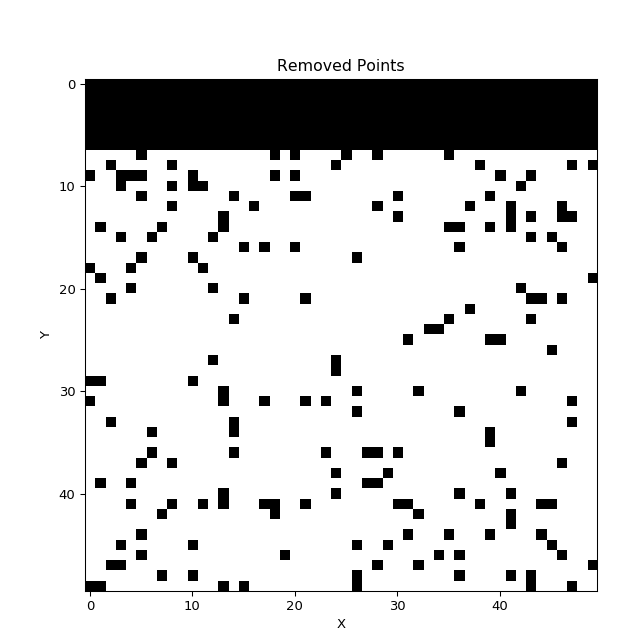

In [83]:
plt.figure()
plt.imshow(remove_map, cmap='binary')
plt.show()
plt.title('Removed Points')
plt.xlabel('X')
plt.ylabel('Y')
fig = plt.gcf()
fig.set_size_inches(7, 7)

meas_acq_flags is a True/False array that is NUM POINTS long. By default everything should be False. If you want to redo and analysis and remove a point, set that point to True. And re-run, fit with clean=True

In [ ]:
remove_matrix

In [84]:
sset._samples[sampName]._meas_acq_flags[meas] = np.reshape(remove_matrix,(2500))
sset._samples[sampName]._meas_acq_flags[meas]


array([ True,  True,  True, ...,  True, False, False])

In [86]:
maps, comps = sset.fit(model, sampstack=sampstack, measstack=measstack, varstack=varstack, inout=inout, plotGroup=plotGroup, clean=True)

In [87]:
# Normalizaze to 0 to 1

# for each component
for i in range(n):
    
    #Pull out the components map and comp
    comp_map = maps.iloc[:,i]
    comp_comp = comps.iloc[i,:]
    
    # What is the map max?
    map_max = np.max(comp_map)
    
    #Adjust map and component according to map max
    new_map = comp_map/map_max
    new_comp = map_max*comp_comp
    
    maps.iloc[:,i] = new_map
    comps.iloc[i,:] = new_comp
    
    
sset._analysis._maps = maps
sset._analysis._comps = comps
    

<IPython.core.display.Javascript object>


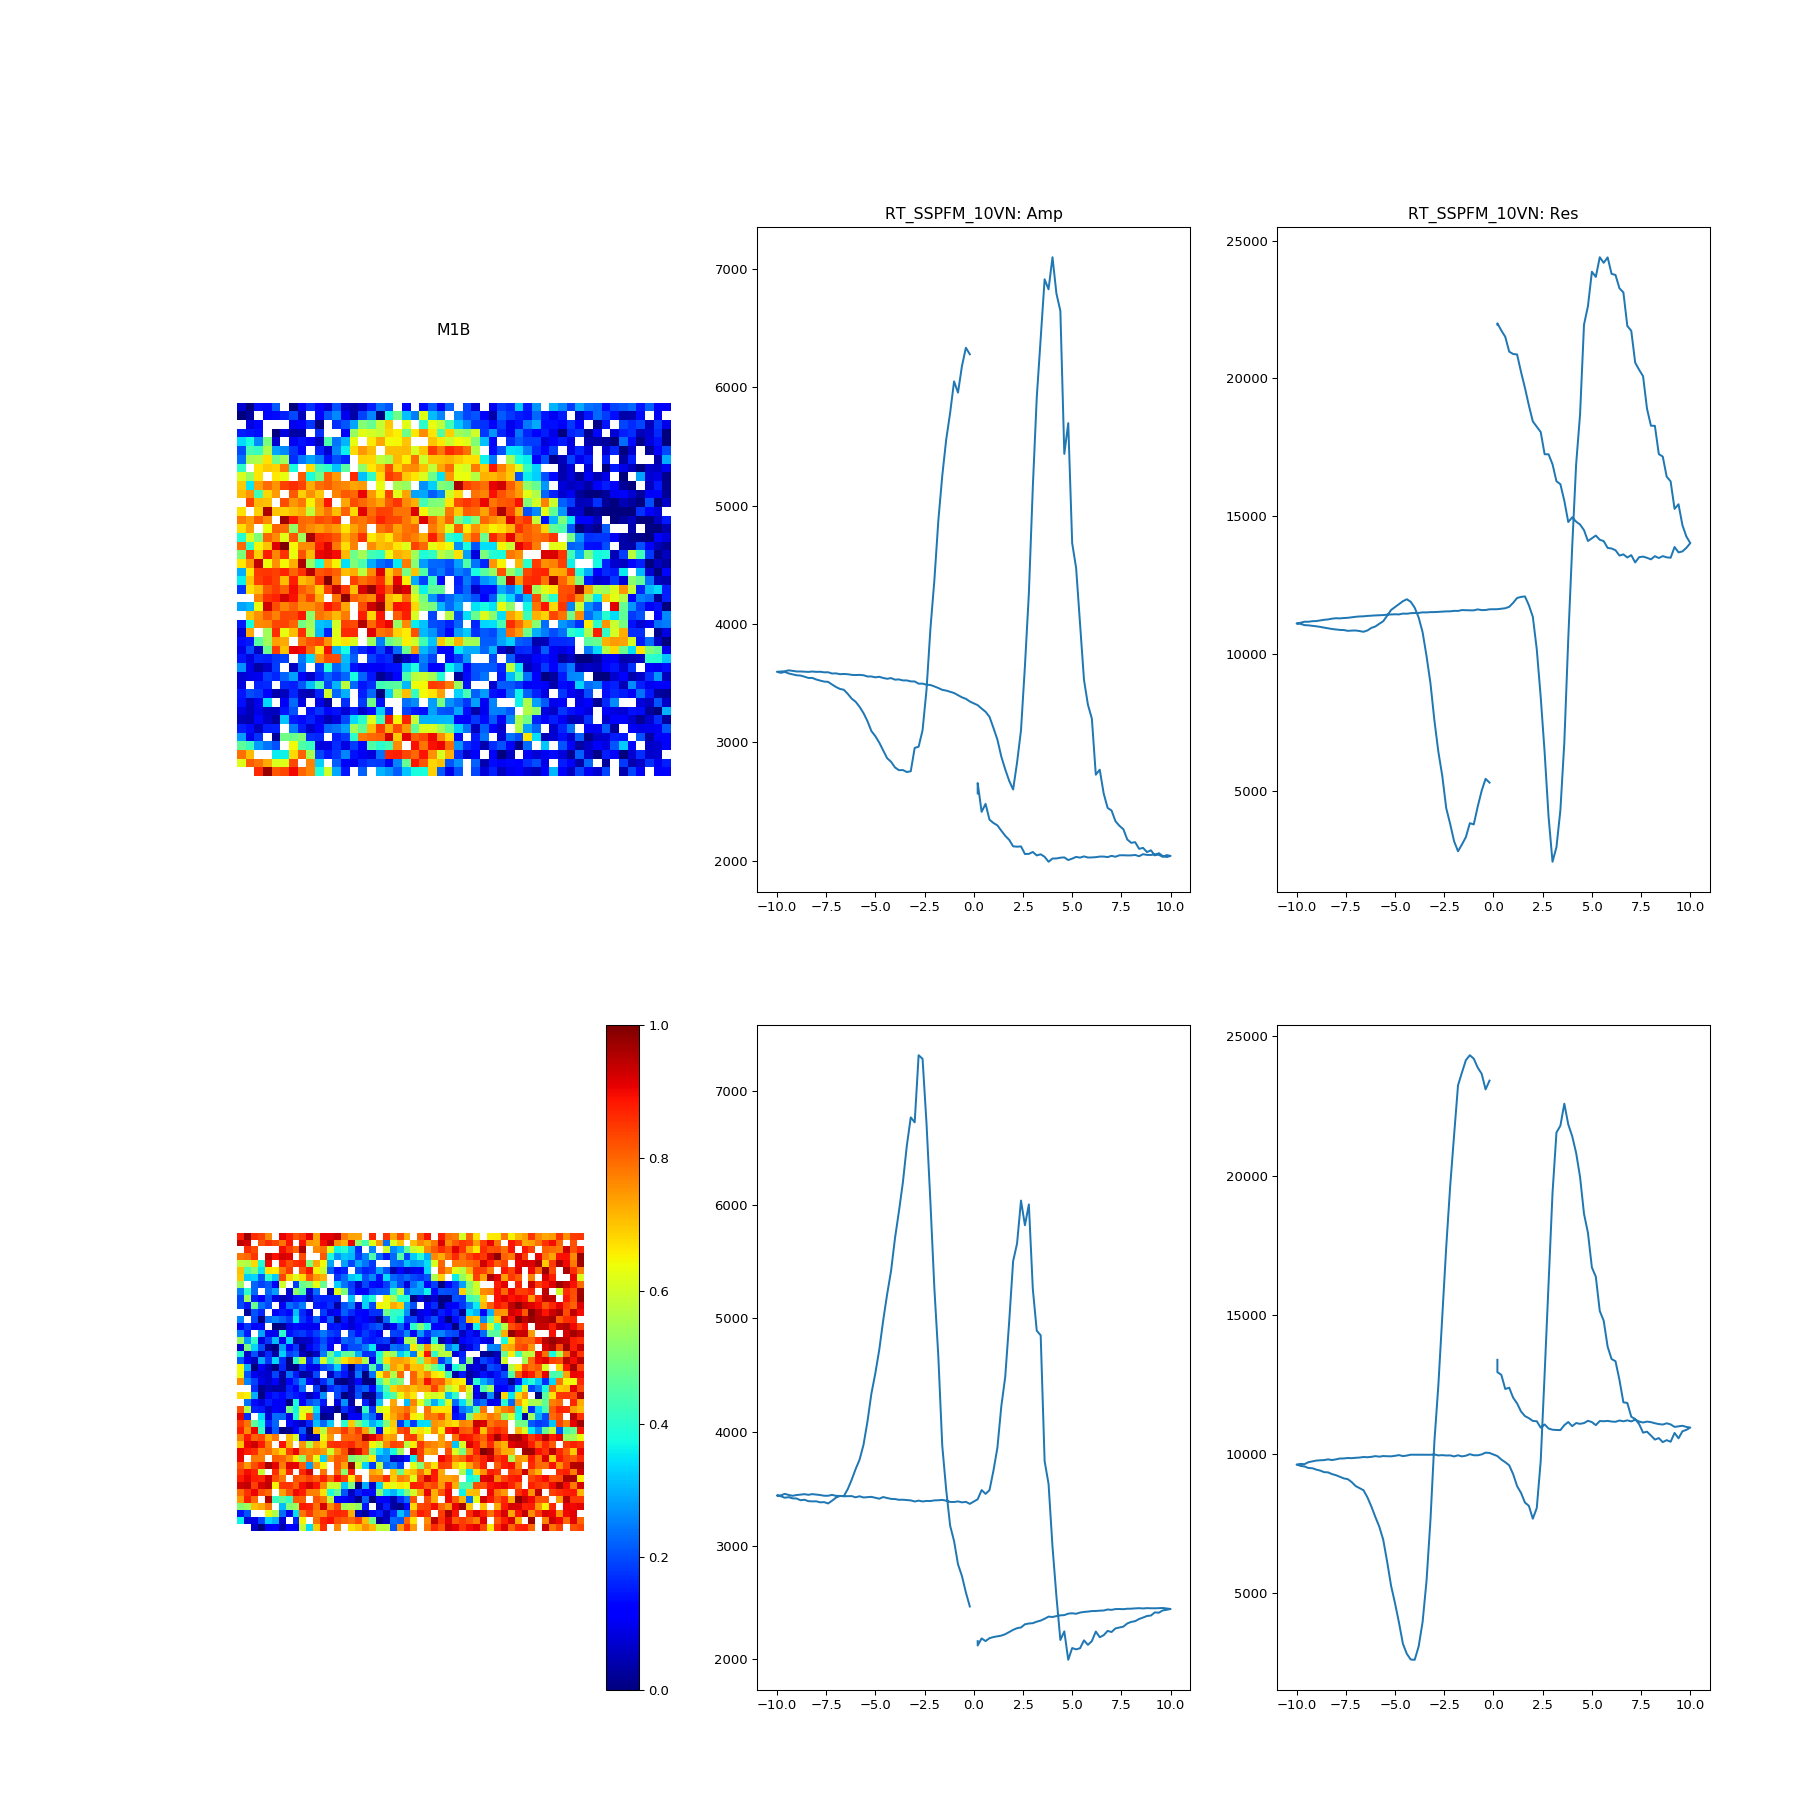

In [88]:
plt.figure()
sset._analysis.plot(norm='ZeroToOne', colorbar=True)
fig = plt.gcf()
fig.set_size_inches(20.0, 20.0)
